# Apply regridding weights to data

See [compute_weights.ipynb](compute_weights.ipynb) for the previous step.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.sparse as sps
import sparse # https://github.com/mrocklin/sparse

## Read regridding weights

In [2]:
ds_w = xr.open_dataset("weights.nc")
ds_w

<xarray.Dataset>
Dimensions:  (n_s: 480000)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 0.6247 0.1253 0.2082 0.04176 0.3747 0.3753 0.1249 ...
    col      (n_s) int32 1 2 401 402 2 3 402 403 3 4 403 404 5 6 405 406 6 7 ...
    row      (n_s) int32 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 ...

In [3]:
n_s = ds_w.dims['n_s']
col = ds_w['col'].values - 1 # Python starts with 0
row = ds_w['row'].values - 1
S = ds_w['S'].values

In [4]:
row.max(), col.max(), S.max()

(119999, 239999, 0.62532626615536413)

## Sparse structure

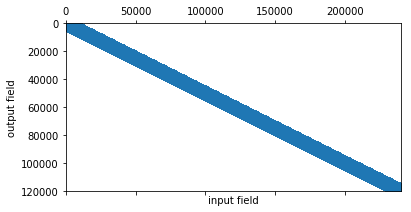

In [5]:
plt.spy( sps.coo_matrix((S, (row, col))) )
plt.xlabel('input field');plt.ylabel('output field')

## Read input data

In [6]:
ds_in = xr.open_dataset('input_data.nc')
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x, time, lev) float64 1.007 2.014 3.021 4.027 5.034 6.041 ...

## Read regridding results by ESMPy for comparision

In [7]:
ds_out = xr.open_dataset('output_data.nc')
ds_out

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x, time, lev) float64 1.009 2.018 3.028 4.037 5.046 6.055 ...

## Array shape tweaking

In [8]:
Nlat_in, Nlon_in, Ntime, Nlev = ds_in['data'].shape
Nlat_out, Nlon_out, _, _ = ds_out['data'].shape

extra_dims = [Ntime, Nlev]

In [9]:
# The weight file assumes Fortan-like ordering 
# Need to change (lat, lon) to (lon, lat) before flatten to 1D

data_in = ds_in['data'].values.swapaxes(0,1)
data_out = np.zeros([Nlon_out, Nlat_out, Ntime, Nlev])

data_in.shape, data_out.shape

((600, 400, 10, 50), (400, 300, 10, 50))

## Flatten lat and lon dimensions for matrix multiplication

In [10]:
# swapaxes+reshape together will make a copy
# not sure how to get a memory view

flat_in = data_in.reshape(Nlat_in*Nlon_in, *extra_dims) # a copy of data_in
flat_out = data_out.reshape(Nlat_out*Nlon_out, *extra_dims) # a view of data_out 

flat_in.shape, flat_out.shape

((240000, 10, 50), (120000, 10, 50))

## Apply regridding weights by hand-written loop

In [11]:
%%time
flat_out[...] = 0.0
for i in range(n_s):
    # sparse matrix multiplication by hand
    # use ... to broadcast across extra dimensions
    flat_out[row[i], ...] += flat_in[col[i], ...]*S[i]

CPU times: user 2.4 s, sys: 10 ms, total: 2.41 s
Wall time: 2.41 s


In [12]:
# exactly the same as reference result
np.allclose(ds_out['data'].values, data_out.swapaxes(0,1))

True

## Applying weights using the sparse library

In [13]:
# make a sparse matrix
A = sparse.COO([S, (row, col)])
A.shape

(120000, 240000)

In [14]:
data_out.max() # contains previous result

999.92751445593331

In [15]:
# clean the output array
flat_out[...] = 0.0
data_out.max()

0.0

In [16]:
# use tensordot for matrix multipication with broadcasting
%time flat_out[...] = sparse.tensordot(A, flat_in, axes=([1],[0]))

CPU times: user 330 ms, sys: 250 ms, total: 580 ms
Wall time: 579 ms


In [17]:
data_out.max() # after regridding

999.92751445593331

In [18]:
# exactly the same as reference result
np.allclose(ds_out['data'].values, data_out.swapaxes(0,1))

True